In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class RatioPlot:
    def __init__(self, h1, h2, h3=None,
                 labels=("A", "B", "C"),
                 rymin=0.85, rymax=1.15,
                 xmin=None, xmax=None,
                 ymin=None, ymax=None,
                 logy=False,
                 outfile="ratio.png"):

        self.h1, self.h2, self.h3 = h1, h2, h3
        self.labels = labels
        self.rymin, self.rymax = rymin, rymax
        self.xmin, self.xmax   = xmin, xmax
        self.ymin, self.ymax   = ymin, ymax
        self.logy              = logy
        self.outfile           = outfile  
        self.xmin_real         = 0.002
        self.xmax_real         = np.pi-self.xmin_real
        self.n_tot             = 200  

    # --------------------------------------------------------
    def _ratio(self, num, den, err_num):
        """Ratio with numerator-only errors."""
        ratio = np.divide(num, den, out=np.zeros_like(num), where=den != 0)
        err   = np.divide(err_num, den, out=np.zeros_like(err_num), where=den != 0)
        return ratio, err

    def _map_x(self, x):
        x = np.asarray(x, dtype=float)
        
        x_lo   = self.xmin_real
        x_hi   = self.xmax_real
        x_mid  = 0.5 * np.pi

        n_tot  = self.n_tot
        n_half = n_tot / 2.0

        out = np.empty_like(x, dtype=float)

        # ---------- left branch (x ≤ π/2) --------------------------
        mask_left = x <= x_mid
        if mask_left.any():
            t = (np.log(x[mask_left]) - np.log(x_lo)) / \
                (np.log(x_mid)       - np.log(x_lo))          
            t = np.clip(t, 0.0, 1.0)
            out[mask_left] = 0.5 + n_half * t                 

        # ---------- right branch (x ≥ π/2) -------------------------
        mask_right = ~mask_left
        if mask_right.any():
            x_rev      = x_hi - x[mask_right]                 # distance to edge
            x_rev_max  = x_hi - x_mid
            x_rev      = np.clip(x_rev, 1e-20, None)          # avoid log(0)
            t = (np.log(x_rev) - np.log(x_lo)) / \
                (np.log(x_rev_max) - np.log(x_lo))            # 1 → 0
            t = np.clip(t, 0.0, 1.0)
            out[mask_right] = n_half + 0.5 + n_half * (1.0 - t)  # 100.5 → 200.5
            
        return out

    # ------------------------------------------------------------------
    def _style_x_axis(self, ax, major_map, minor_map, major_labels):
        """Common cosmetics for both pads."""
        ax.set_xlim(0.5, self.n_tot+0.5)

        # long (labelled) and short (unlabelled) ticks
        ax.set_xticks(major_map)
        ax.set_xticklabels(major_labels)
        ax.set_xticks(minor_map, minor=True)

        # tick geometry + ticks on all four sides
        ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
        ax.tick_params(axis='x', which='major', length=8)
        ax.tick_params(axis='x', which='minor', length=4)

    def draw(self):
        c1, e1, centers  = self.h1
        c2, e2, _        = self.h2
        has_h3 = self.h3 is not None

        if has_h3:
            c3, e3, _ = self.h3

        # ratios
        r2, er2 = self._ratio(c2, c1, e2)
        if has_h3:
            r3, er3 = self._ratio(c3, c1, e3)
        r1 = np.ones_like(r2)

        # ---------------- figure & pads ------------------
        fig = plt.figure(figsize=(8, 6), dpi=120)
        gs  = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)          # share x

        # --- long ticks and labels ---------------------------------------
        major_phys   = np.array([0.01,
                                 0.10,
                                 1.00,
                                 self.xmax_real - 1.00,
                                 self.xmax_real - 0.10,
                                 self.xmax_real - 0.01])

        major_labels = [r"$0.01$",
                        r"$0.1$",
                        r"$1$",
                        r"$\pi-1$",
                        r"$\pi-0.1$",
                        r"$\pi-0.01$"]

        # --- short ticks (no labels) ---------------------------------------
        minor_left  = ( [self.xmin_real + 0.001*i for i in range(9)]      # 0.002 … 0.010
                      + [0.01  + 0.01*i  for i in range(10)]      # 0.010 … 0.100
                      + [0.10  + 0.10*i  for i in range(10)])     # 0.100 … 1.000

        minor_right = [np.pi - self.xmin_real - v for v in minor_left]     # mirror about π/2
        minor_phys  = np.array(sorted(set(minor_left + minor_right)))

        # --- mapping tick positions ----------------------------
        major_map  = self._map_x(major_phys)   
        minor_map  = self._map_x(minor_phys)

        centers_int = np.arange(1, self.n_tot+1)
        
        # ---------------- upper pad ----------------------
        self._style_x_axis(ax1, major_map, minor_map, major_labels)

        ax1.errorbar(centers_int, c1, yerr=e1, fmt="o", ms=2, color="black", label=self.labels[0])
        ax1.errorbar(centers_int, c2, yerr=e2, fmt="s", ms=2, color="red",   label=self.labels[1])
        if has_h3:
            ax1.errorbar(centers_int, c3, yerr=e3, fmt="^", ms=2, color="green", label=self.labels[2])

        if self.logy:
            ax1.set_yscale("log")
        if self.ymin is not None or self.ymax is not None:
            ax1.set_ylim(self.ymin, self.ymax)

        ax1.set_ylabel("EEC")
        ax1.legend(frameon=False, fontsize=10)
        ax1.tick_params(labelbottom=False)        # hides x-labels on upper pad

        # ---------------- lower pad ----------------------
        self._style_x_axis(ax2, major_map, minor_map, major_labels)

        ax2.plot(centers_int, r1, "o", ms=2, color="black")
        ax2.errorbar(centers_int, r2, yerr=er2, fmt="s", ms=2, color="red")
        if has_h3:
            ax2.errorbar(centers_int, r3, yerr=er3, fmt="^", ms=2, color="green")

        ax2.axhline(1.0, color="gray", lw=1)
        ax2.set_ylim(self.rymin, self.rymax)
        ax2.set_ylabel("Ratio", labelpad=8)
        ax2.set_xlabel(r"$\theta_L$")
        ax2.set_yticks(np.linspace(self.rymin, self.rymax, 5))

        # ---------------- save ---------------------------
        fig.savefig(self.outfile, bbox_inches="tight")
        plt.close(fig)

In [5]:
import ROOT

def bin_centers(edges):
    return 0.5 * (edges[1:] + edges[:-1])

def divide_bin_width(h):
    h_out = h.Clone()
    h_out.SetDirectory(0)
    for i in range(1, h.GetNbinsX() + 1):
        bw = h.GetBinWidth(i)
        h_out.SetBinContent(i, h.GetBinContent(i) / bw)
        h_out.SetBinError  (i, h.GetBinError(i)   / bw)
    return h_out


def th1_to_numpy(h):
    """
    Convert TH1 -> (counts, errors, edges) NumPy arrays.
    Counts and errors include **all** scaling already applied to the TH1.
    """
    nbins = h.GetNbinsX()
    counts = np.fromiter((h.GetBinContent(i + 1) for i in range(nbins)), float)
    errors = np.fromiter((h.GetBinError  (i + 1) for i in range(nbins)), float)

    edges = np.empty(nbins + 1, dtype=float)
    for i in range(nbins):
        edges[i] = h.GetBinLowEdge(i + 1)
    edges[-1] = edges[-2] + h.GetBinWidth(nbins)
    centers = bin_centers(edges)
    return counts, errors, centers

Wrote EEC_comparison.png


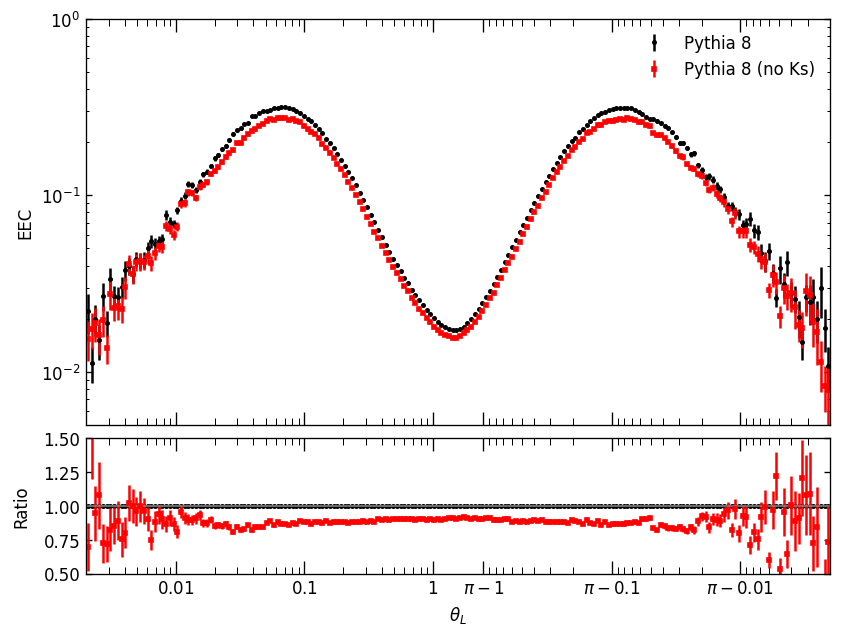

In [6]:
ROOT.gROOT.SetBatch(True)   # suppress canvases

# ---------------- file 1 ---------------------------
f1   = ROOT.TFile.Open("hgen_Pythia_v11.root")
h1   = f1.Get("EEC_r_before").Clone()
norm1 = f1.Get("N").GetBinContent(2)

h1   = divide_bin_width(h1)
h1.Scale(1.0 / norm1)

# ---------------- file 2 ---------------------------
f2   = ROOT.TFile.Open("hgen_Pythia_v12.root")
h2   = f2.Get("EEC_r_before").Clone()
norm2 = f2.Get("N").GetBinContent(2)

h2   = divide_bin_width(h2)
h2.Scale(1.0 / norm2)

# convert to numpy triplets
h1_np = th1_to_numpy(h1)
h2_np = th1_to_numpy(h2)

outname = "EEC_comparison.png"
# ---------------- plot -----------------------------
plot = RatioPlot(
    h1_np, h2_np,
    labels=("Pythia 8", "Pythia 8 (no Ks)"),
    rymin=0.5, rymax=1.5,
    ymin=0.005, ymax=1,
    logy=True,
    outfile=outname
)
plot.draw()
print(f"Wrote {outname}")

try:
    from IPython.display import Image, display
    display(Image(outname))
except ImportError:
    pass